In [271]:
# Initialize Otter
import otter
grader = otter.Notebook("proj2b.ipynb")

# Project 2B: Spam/Ham Classification - Build Your Own Model

## Feature Engineering, Classification, Cross Validation
## Due Date: Sunday 4/28, 11:59 PM PDT

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this project, you will be building and improving on the concepts and functions that you implemented in Project 2A to create your own classifier to distinguish spam emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

In [272]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1 | 6
2a | 4
2b | 2
3 | 3
4 | 15
Total | 30

## Setup and Recap

Here we will provide a summary of Project 2A to remind you of how we cleaned the data, explored it, and implemented methods that are going to be useful for building your own model.

In [273]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading and Cleaning Data

Remember that in email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cell to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [274]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [275]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [276]:
len(original_training_data), len(test)

(8348, 1000)

Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [277]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We therefore split the training data into separate training and validation datsets. You will need this **validation data** to assess the performance of your classifier once you are finished training. 

As in Project 2A, we set the seed (random_state) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [278]:
# This creates a 90/10 train-validation split on our labeled data
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

In [279]:
(len(train), len(val))

(7513, 835)

### Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. To address this, in Project 2A, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this project, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [280]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

Run the following cell to see how the function works on some dummy text.

In [281]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
...,...,...,...,...
8343,8343,Subject: Re: ALSA (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0
8344,8344,Subject: Re: Goodbye Global Warming\n,thanks for the link - i'm fascinated by archae...,0
8345,8345,Subject: hello\n,we need help. we are a 14 year old fortune 50...,1
8346,8346,Subject: Your application is below. Expires Ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1


### EDA and Basic Classification

In Project 2A, we proceeded to visualize the frequency of different words for both spam and ham emails, and used `words_in_texts(words, train['email'])` to directly to train a classifier. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `scikit-learn`.

Run the following cell to see the performance of a simple model using these words and the `train` dataframe.

In [282]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [283]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


### Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. In Project 2A, we calculated various metrics to lead us to consider more ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

![precision_recall](precision_recall.png)

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

# Moving Forward - Building Your Own Model

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No decision trees, random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 1, 2, and 3 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

---

In [284]:
ham_train = train[train['spam'] == 0]
spam_train = train[train['spam'] == 1]

In [285]:
from collections import Counter
ham_train = train[train['spam'] == 0].head(len(ham_train))
spam_train = train[train['spam'] == 1].head(len(ham_train))

spam_train['exclamation'] = spam_train['email'].str.count("!")
spam_exclamation_average = np.average(spam_train['exclamation'])

ham_train['exclamation'] = ham_train['email'].str.count("!")
ham_exclamation_average = np.average(ham_train['exclamation'])

print("spam exclamation average:", spam_exclamation_average,
      "ham exclamation average:", ham_exclamation_average)

spam_train['body length'] = spam_train['email'].str.len()
spam_body_length_average = np.average(spam_train['body length'])

ham_train['body length'] = ham_train['email'].str.len()
ham_body_length_average = np.average(ham_train['body length'])

print("spam body length average: ", spam_body_length_average,
      "ham body length average: ", ham_body_length_average)

spam_train['subject length'] = spam_train['subject'].str.len()
spam_subject_length_average = np.average(spam_train['subject length'])

ham_train['subject length'] = ham_train['subject'].str.len()
ham_subject_length_average = np.average(ham_train['subject length'])

print("spam subject length average: ", spam_subject_length_average,
      "ham subject length average: ", ham_subject_length_average)

spam_train['email'] = spam_train['email'].str.replace("\n", "")
spam_train['email'] = spam_train['email'].str.replace("[^\w\s]", "")

ham_train['email'] = ham_train['email'].str.replace("\n", "")
ham_train['email'] = ham_train['email'].str.replace("[^\w\s]", "")

spam_list = spam_train['email'].tolist()
spam_string = ""
for item in spam_list:
    spam_string = spam_string + item
    
fillers = ['the', 'a', 'an', 'be', 'of', 'and', 'in', 'that', 'have', 'it', 'for', 'not', 'on', 'with', 'he', 'as', 'this', 'but', 'to', 'i', 'are'
          'will', 'or', 'can', 'is']
    
spam_split = spam_string.split()
filtered_spam_split = [item for item in spam_split if item not in fillers]

filtered_spam_split

ham_list = ham_train['email'].tolist()
ham_string = ""
for item in ham_list:
    ham_string = ham_string + item
    
ham_split = ham_string.split()
filtered_ham_split = [item for item in ham_split if item not in fillers]

spamCounter = Counter(filtered_spam_split)
spamCommon = spamCounter.most_common(200)

spamWords = []
for i in range(len(spamCommon)):
    spamWords.append(spamCommon[i][0])
    
hamCounter = Counter(filtered_ham_split)
hamCommon = hamCounter.most_common(200)

hamWords = []
for i in range(len(hamCommon)):
    hamWords.append(hamCommon[i][0])
    
spamWords = [item for item in spamWords if item not in hamWords]
spamWords = spamWords + ['free investment', 'credit cards', 'act now', 'opt in',
             'bankruptcy', 'potential earnings', 'get paid', 'bill', 'cancel',
             'save up to', 'lowest price', 'click below', 'delete', 'sex', 'viagra']

spam exclamation average: 6.470281543274244 ham exclamation average: 2.0875781948168006
spam body length average:  5528.656412930136 ham body length average:  2986.5805183199286
spam subject length average:  50.42283628779979 ham subject length average:  46.38999106344951


In [286]:
wordsArray = words_in_texts(spamWords, train['email'])
finalTable = pd.DataFrame(wordsArray, columns = spamWords)
finalTable['exclamation'] = train['email'].str.count("!")
finalTable['log body length'] = np.log(train['email'].str.len())
finalTable['subject length'] = train['subject'].str.len()
finalTable['spam'] = train['spam']
finalTable

X_train = finalTable.drop(['spam'], axis = 1)
Y_train = finalTable['spam']

In [287]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9019033674963397


In [288]:
testArray = words_in_texts(spamWords, val['email'])
testTable = pd.DataFrame(testArray, columns = spamWords)
testTable['exclamation'] = val['email'].reset_index()['email'].str.count("!")
testTable['log body count'] = np.log(val['email'].reset_index()['email'].str.len())
testTable['subject length'] = val['subject'].reset_index()['subject'].str.len()
testTable['spam'] = val['spam'].reset_index()['spam']
testTable

X_val = testTable.drop(['spam'], axis = 1)
Y_val = testTable['spam']

In [289]:
test_accuracy = model.score(X_val, Y_val)
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.8982035928143712


In [290]:
subArray = words_in_texts(spamWords, test['email'])
subTable = pd.DataFrame(subArray, columns = spamWords)
subTable['exclamation'] = test['email'].reset_index()['email'].str.count("!")
subTable['log body count'] = np.log(test['email'].reset_index()['email'].str.len())
subTable['subject length'] = test['subject'].reset_index()['subject'].str.len()
subTable

,sansserif,face3darial,div,tr20,body,money,business,option,receive,send,...,cancel,save up to,lowest price,click below,delete,sex,viagra,exclamation,log body count,subject length
0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,9.367600,55.0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,7,6.650279,46.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.972606,45.0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,5.262690,41.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6.825460,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,7.323831,41.0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.533389,36.0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.429719,27.0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6.680855,47.0


In [291]:
subTable.loc[subTable['subject length'].isnull(),"subject length"] = 0
subTable.isnull().sum()

sansserif         0
face3darial       0
div               0
tr20              0
body              0
                 ..
sex               0
viagra            0
exclamation       0
log body count    0
subject length    0
Length: 103, dtype: int64

In [292]:
len(model.predict(subTable))

1000

<!-- BEGIN QUESTION -->

### Question 1: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q1
manual: True
points: 6
-->

1) In order to build a better model, I decided to not only increase the number of words fed into the model, but also find ones that feature predominantly in spam emails. In order to do this, I split up the training data into spam and ham portions and considered each dataframe separately. My earlier EDA had shown that spam emails seem to have a much higher number of exclamation marks on average than normal emails and in order to verify this, I used the .str.count("!") function to find the number of exclamation marks in each row of both the spam and ham dataframes. This did indeed reveal a difference, with spam emails having on average 6 exclamations per email while ham emails only have on average 2 exclamations per email. I also included columns to factor in the subject and body length of emails (with spam emails being typically much longer than ham emails). Next, I wanted to find good words to use for my features. To do this, I concatanated all the rows for both dataframes into a single item and split this. For each item in these lists, I removed words that are considered filler words (and therefore don't have much meaning) to end up with a list of the 200 most common words used in spam emails. Then, to eliminate words that also appear in the ham list, I did one more layer of filtering to end up with 85 words to use as features.

2) I noticed that just increasing the number of words used does not necessarily equate to less training error. This is likely because a lot of words don't have a meaning that is relevant to only spam emails or only ham emails and thus may feature in both. In addition, the subject length seems to not really matter that much because both spam and ham emails have very similar subject lengths.

3) I was surprised that using the log of the body length made a pretty sizable difference to the training and test accuracy. While I understand that taking the log of an exponential graph linearizes it, spam and ham emails on average only differ by 2000 characters in body length. In addition, I was also surprised that at how much additional random jargon spam emails had which made such items good features to use in my model.

<!-- END QUESTION -->



Optional: Build a Decision Tree model with reasonably good accuracy. What features does the decision tree use first?

### Question 2: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to Question 3 in Project 2A.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

#### Question 2a

Generate your visualization in the cell below.

<!--
BEGIN QUESTION
name: q2a
manual: True
format: image
points: 4
-->

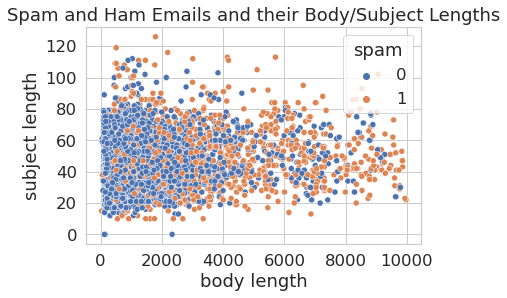

In [293]:
train_data = train.copy()
train_data['body length'] = train_data['email'].str.len()
train_data['subject length'] = train_data['subject'].str.len()
train_data = train_data[train_data['body length'] < 10000]

sns.scatterplot(data = train_data, x = "body length", y = "subject length", hue = "spam")
plt.title("Spam and Ham Emails and their Body/Subject Lengths")
sns.set(rc = {'figure.figsize':(8, 15)})

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Question 2b

Write your commentary in the cell below.

<!--
BEGIN QUESTION
name: q2b
manual: True
points: 2
-->

One feature that I thought would be interesting to use is the body and subject length of emails. From the graph above, we can see that there are many more orange dots (indicating spam emails) towards the right side of the plot. This indicates that on average, spam emails will be longer than ham emails and this therefore could be a very useful feature to use in our classifier.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 20 to see how to plot an ROC curve.

**Hint**: You'll want to use the `.predict_proba` method for your classifier instead of `.predict` so you get probabilities instead of binary predictions.

<!--
BEGIN QUESTION
name: q3
manual: True
points: 3
-->

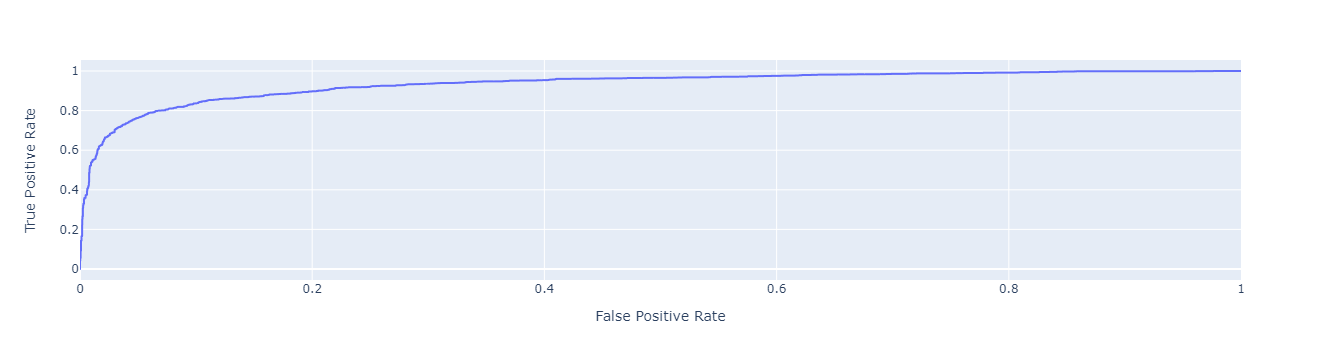

In [294]:
from sklearn.metrics import roc_curve
import plotly.express as px

y_predictions = model.predict_proba(X_train)[:, 1]

false_positive, true_positive, threshold = roc_curve(Y_train, y_predictions)
(false_positive, true_positive, threshold)

fig = px.line(x = false_positive, y = true_positive, hover_name =threshold)
fig.update_xaxes(title = 'False Positive Rate')
fig.update_yaxes(title = 'True Positive Rate')
fig

<!-- END QUESTION -->

# Question 4: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "k Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q4
points: 3
-->

In [295]:
test_predictions = model.predict(subTable)

In [296]:
grader.check("q4")

q4 results: All test cases passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project 2B Test Predictions" assignment on Gradescope to get credit for this question.**

Note that the file will appear in your DataHub, you must navigate to the `hw11` directory in your DataHub to download the file.

In [226]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2022-04-28T13:49:13.csv.
You may now upload this CSV file to Gradescope for scoring.


## Congratulations! You have completed Project 2B!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [297]:
grader.check_all()

q4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [298]:
# Save your notebook first, then run this cell to export your submission.
grader.export()